In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf

import gensim
from gensim.models import Word2Vec
import gensim.corpora as corpora
from gensim.models import TfidfModel, CoherenceModel, LdaMulticore
from gensim import models
from gensim.utils import simple_preprocess
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

e:\Users\Beast-Of-War\miniconda3\envs\hugface\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


e:\Users\Beast-Of-War\miniconda3\envs\hugface\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
data = pd.read_csv("data_bag.csv")

import ast

def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

data['Tags'] = data['Tags'].apply(convert_tags)

# Compter les occurrences de chaque tag
tag_counts = {}
for row in data['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])
# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data['Title'] = data['Title'].str.split(" ")
data = data.drop('Id', axis=1)

In [3]:
top_number = 100
# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(top_number)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data['Tags'] = data['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",top_number,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data = data[data['Tags'].apply(len) > 0]

Les 100 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter', 'html', 'typescript', 'pandas', 'ios', 'docker', 'python-3.x', 'swift', 'css', 'spring-boot', 'kotlin', 'dataframe', 'amazon-web-services', 'php', 'react-native', 'dart', 'firebase', 'vue.js', 'arrays', 'django', 'angular', 'spring', 'c', 'next.js', 'azure', 'git', 'numpy', 'json', 'tensorflow', 'kubernetes', 'linux', 'swiftui', 'macos', 'github', 'windows', 'asp.net-core', 'algorithm', 'postgresql', 'sql', 'visual-studio-code', 'android-studio', 'laravel', 'xcode', 'apache-spark', 'npm', 'android-jetpack-compose', 'jquery', 'performance', 'mongodb', 'webpack', 'multithreading', 'pyspark', 'express', 'keras', 'machine-learning', 'docker-compose', 'list', 'gradle', 'google-cloud-platform', 'excel', 'pytorch', 'selenium', 'c++20', 'react-hooks', 'mysql', 'dplyr', 'wordpress', 'unit-testing', 'go', 'api', 'jestjs', 'powershell', 'string', 'deep-learning', 'openc

In [4]:
data.head(10)

,Title,Tags
0,"[construct, object, alloc, stdallocatoralloc]","[c++, c++20]"
1,"[react, router, block, rout, chang, createbrow...","[javascript, reactjs]"
3,"[flutter, firebas, control, notif, show, app, ...","[ios, flutter]"
4,"[roll, idxminmax, panda, datafram]","[python, pandas, dataframe]"
5,"[process, finish, exit, code, interrupt, signa...","[python, pandas, numpy]"
6,"[tri, read, regist, valu, process, task_struct]",[c]
7,"[anchor, link, work, properli, desktop, work, ...","[javascript, html, css]"
8,"[uwsgi, error, pcre, ubuntu, 2004, error, load...",[python-3.x]
9,"[error, could, deseri, data, use, algorithm, d...",[django]
10,"[cant, scrape, compani, name, webpag]","[python, python-3.x]"


In [5]:
texts = data['Title'].tolist()
print(f"Nombre de documents: {len(texts)}")
print(f"Nombre de mots uniques avant filtrage: {len(set([word for text in texts for word in text]))}")

Nombre de documents: 46298
Nombre de mots uniques avant filtrage: 24443


In [6]:
# Création du dictionnaire
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5)
print(f"Nombre de mots uniques après filtrage: {len(id2word)}")

# Création du corpus BOW et TF-IDF
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

Nombre de mots uniques après filtrage: 3771


In [7]:
# Fonction pour calculer les valeurs de cohérence
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             random_state=42,
                             passes=10,
                             workers=7)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
# Calcul des valeurs de cohérence
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)

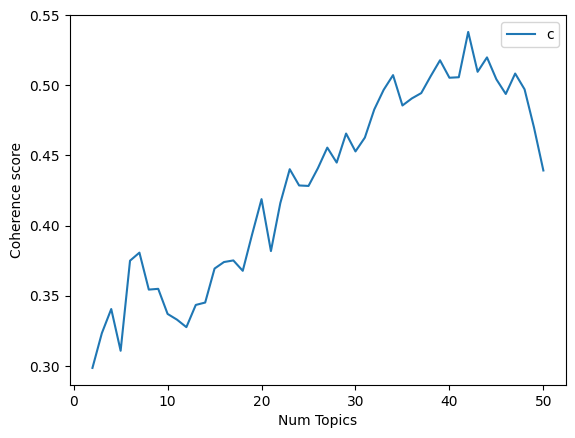

Num Topics = 2  has Coherence Value of 0.2985
Num Topics = 3  has Coherence Value of 0.3232
Num Topics = 4  has Coherence Value of 0.3405
Num Topics = 5  has Coherence Value of 0.3107
Num Topics = 6  has Coherence Value of 0.3749
Num Topics = 7  has Coherence Value of 0.3807
Num Topics = 8  has Coherence Value of 0.3543
Num Topics = 9  has Coherence Value of 0.3549
Num Topics = 10  has Coherence Value of 0.337
Num Topics = 11  has Coherence Value of 0.3329
Num Topics = 12  has Coherence Value of 0.3275
Num Topics = 13  has Coherence Value of 0.3434
Num Topics = 14  has Coherence Value of 0.3451
Num Topics = 15  has Coherence Value of 0.3693
Num Topics = 16  has Coherence Value of 0.374
Num Topics = 17  has Coherence Value of 0.3751
Num Topics = 18  has Coherence Value of 0.3677
Num Topics = 19  has Coherence Value of 0.3938
Num Topics = 20  has Coherence Value of 0.4188
Num Topics = 21  has Coherence Value of 0.3818
Num Topics = 22  has Coherence Value of 0.416
Num Topics = 23  has Coh

In [9]:
# Affichage des résultats
limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [18]:
print("la cohérence est maximale à",max(coherence_values),"avec",2+coherence_values.index(max(coherence_values)),"topics")

la cohérence est maximale à 0.538087530346396 avec 42 topics


In [21]:
# Sélectionner le modèle avec la meilleure cohérence
optimal_model = model_list[coherence_values.index(max(coherence_values))]

# Afficher les sujets
def display_topics(model, num_words):
    for idx, topic in model.print_topics(num_topics=-1, num_words=num_words):
        print(f"Topic {idx}:\n{topic}\n")

display_topics(optimal_model, num_words=15)

Topic 0:
0.038*"null" + 0.036*"rang" + 0.030*"permiss" + 0.029*"disabl" + 0.027*"pytorch" + 0.025*"equival" + 0.023*"system" + 0.021*"repeat" + 0.020*"socket" + 0.019*"deni" + 0.018*"train" + 0.017*"safari" + 0.017*"volum" + 0.016*"nuxt" + 0.015*"multi"

Topic 1:
0.043*"loop" + 0.032*"merg" + 0.025*"plotli" + 0.024*"event" + 0.023*"combin" + 0.022*"automat" + 0.020*"case" + 0.019*"listen" + 0.019*"postgresql" + 0.019*"hook" + 0.019*"rule" + 0.016*"seri" + 0.015*"continu" + 0.015*"devic" + 0.013*"expand"

Topic 2:
0.057*"import" + 0.048*"studio" + 0.031*"visual" + 0.025*"android" + 0.024*"modul" + 0.024*"found" + 0.020*"load" + 0.019*"wrong" + 0.016*"cannot" + 0.016*"runtim" + 0.016*"error" + 0.014*"worker" + 0.014*"intern" + 0.012*"configur" + 0.012*"airflow"

Topic 3:
0.040*"handl" + 0.039*"block" + 0.037*"except" + 0.035*"larg" + 0.035*"posit" + 0.028*"expect" + 0.028*"messag" + 0.023*"callback" + 0.018*"mongoos" + 0.018*"subscript" + 0.015*"twice" + 0.015*"entri" + 0.014*"registri" 

In [27]:
# Assigner les sujets aux questions et récupérer plusieurs sujets par question
topic_assignments = optimal_model.get_document_topics(tfidf_corpus, minimum_probability=0.025)
data['assigned_topics'] = [sorted(doc, key=lambda x: x[1], reverse=True) for doc in topic_assignments]

# Sélectionner les top N sujets (par exemple, top 3 sujets) pour chaque question
top_n = 3
data['top_topics'] = data['assigned_topics'].apply(lambda x: [topic[0] for topic in x[:top_n]])


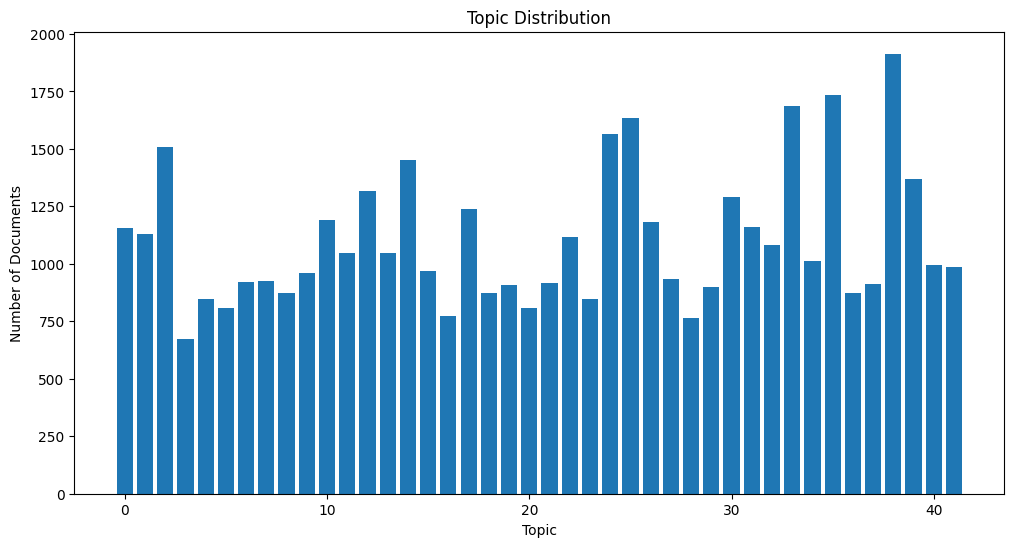

In [23]:
# Sélectionner le sujet le plus significatif pour chaque question
data['most_significant_topic'] = data['assigned_topics'].apply(lambda x: x[0][0])

# Calculer la répartition des sujets
topic_distribution = data['most_significant_topic'].value_counts().sort_index()

# Afficher la répartition des sujets
plt.figure(figsize=(12, 6))
plt.bar(topic_distribution.index, topic_distribution.values)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.show()

En se basant sur les valeur les plus represnetatitve des topic nous avons la correspondance : 

In [32]:
topic_to_tag = {
    0: "null",
    1: "loop",
    2: "import",
    3: "error-handling",
    4: "optimization",
    5: "logging",
    6: "authentication",
    7: "xcode",
    8: "database",
    9: "rendering",
    10: "api",
    11: "multithreading",
    12: "python",
    13: "pyspark",
    14: "swiftui",
    15: "websockets",
    16: "gradle",
    17: "sql",
    18: "testing",
    19: "vscode",
    20: "debugging",
    21: "numpy",
    22: "android",
    23: "nestjs",
    24: "mysql",
    25: "git",
    26: "backend",
    27: "plotting",
    28: "graphql",
    29: "laravel",
    30: "testing",
    31: "spring-boot",
    32: "error-handling",
    33: "react",
    34: "testing",
    35: "cloud",
    36: "web-scraping",
    37: "node.js",
    38: "pandas",
    39: "performance",
    40: "css",
    41: "tensorflow",
    42: "api"
}

In [34]:
# Mapper les identifiants des sujets aux tags
data['tags_estimated'] = data['top_topics'].apply(lambda topics: [topic_to_tag.get(topic, 'unknown') for topic in topics])

# Sauvegarder le résultat
data.to_csv('tagged_questions.csv', index=False)

# Afficher quelques exemples
print(data[['Tags', 'tags_estimated']].head(10))

                           Tags                          tags_estimated
0                  [c++, c++20]                   [react, web-scraping]
1         [javascript, reactjs]                 [react, error-handling]
3                [ios, flutter]                     [cloud, websockets]
4   [python, pandas, dataframe]                [pandas, authentication]
5       [python, pandas, numpy]          [error-handling, graphql, git]
6                           [c]                 [web-scraping, swiftui]
7       [javascript, html, css]  [debugging, performance, web-scraping]
8                  [python-3.x]            [performance, gradle, xcode]
9                      [django]         [testing, spring-boot, testing]
10         [python, python-3.x]          [vscode, import, web-scraping]


In [44]:
import os
save_directory = "./models/lda/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Sauvegarder le modèle LDA
model_path = os.path.join(save_directory, "lda_model")
optimal_model.save(model_path)